1. Imports + pathsetup

In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

MAT_PATH = PROJECT_ROOT / "data" / "raw" / "Data_Shariftabar_Nouri.mat"

# Import project functions
from data_loader import load_raw_mat, list_user_keys, find_channels_data, parse_one_cell, build_records

2. Load + parse

In [2]:
raw = load_raw_mat(MAT_PATH)
keys = list_user_keys(raw)

channels_data, varname = find_channels_data(raw)
records = build_records(channels_data)

print(f"keys={keys}")
print(f"var={varname}, shape={channels_data.shape}, records={len(records)}")

keys=['channels_data']
var=channels_data, shape=(4, 10), records=40


3. Quick sanity report 

In [3]:
lengths = np.array([len(r.data) for r in records])
label_counts = np.array([0 if r.labels is None else len(r.labels) for r in records])
locs_counts = np.array([0 if r.locs is None else len(r.locs) for r in records])

print("Signal N (min/mean/max):", lengths.min(), int(lengths.mean()), lengths.max())
print("Labels count unique:", sorted(set(label_counts.tolist())))
print("Locs count unique:", sorted(set(locs_counts.tolist())))

# Show one example
r0 = records[0]
print("\nExample (ch=1, block=1)")
print("N:", len(r0.data))
print("labels[:5]:", None if r0.labels is None else r0.labels[:5])
print("locs[:5]:", None if r0.locs is None else r0.locs[:5])

Signal N (min/mean/max): 21327 22466 23327
Labels count unique: [21]
Locs count unique: [21]

Example (ch=1, block=1)
N: 21977
labels[:5]: ['Rest', 'Get', 'Hold', 'Forward', 'F-Hold']
locs[:5]: [ 876. 2046. 2946. 3926. 4976.]


--------------------------------

1. Build + Save cache

In [5]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from cache_io import build_cache_from_mat, save_npz_cache

MAT_PATH = PROJECT_ROOT / "data" / "raw" / "Data_Shariftabar_Nouri.mat"
NPZ_PATH = PROJECT_ROOT / "data" / "interim" / "emg_cache.npz"

cache = build_cache_from_mat(MAT_PATH)
out = save_npz_cache(cache, NPZ_PATH)

print("Saved cache to:", out)
print("Cache keys:", len(cache))
print("Shape:", cache["meta__shape"])
print("Main var:", cache["meta__main_var"][0])
print("First 5 labels:", cache["meta__labels_order"][:5])

Saved cache to: c:\Users\Notebook\emg-hand-gesture-classification\data\interim\emg_cache.npz
Cache keys: 123
Shape: [ 4 10]
Main var: channels_data
First 5 labels: ['Rest' 'Get' 'Hold' 'Forward' 'F-Hold']


2. Load Cache

Loaded cache: c:\Users\Notebook\emg-hand-gesture-classification\data\interim\emg_cache.npz
Num channel-block pairs: 40
First 5 pairs: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
Example: N= 21977 locs= 21 labels= 21
labels[:5]= ['Rest', 'Get', 'Hold', 'Forward', 'F-Hold', 'F-Return', 'Hold', 'Backward', 'B-Hold', 'B-Return', 'Hold', 'Right', 'R-Hold', 'R-Return', 'Hold', 'Left', 'L-Hold', 'L-Return', 'Hold', 'Free', 'Rest']
locs[:5]= [  876.  2046.  2946.  3926.  4976.  5986.  6986.  8066.  8916.  9926.
 11006. 11976. 13006. 13866. 14926. 16026. 16986. 17976. 18986. 19976.
 20956.]


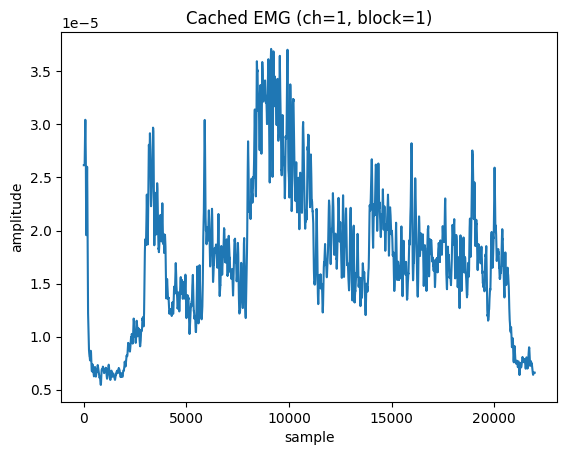

In [11]:
from cache_io import load_npz_cache, list_records_in_cache, get_record_from_cache
import numpy as np
import matplotlib.pyplot as plt

cache = load_npz_cache(NPZ_PATH)
pairs = list_records_in_cache(cache)

print("Loaded cache:", NPZ_PATH)
print("Num channel-block pairs:", len(pairs))
print("First 5 pairs:", pairs[:5])

data, locs, labels = get_record_from_cache(cache, channel=1, block=1)
print("Example: N=", len(data), "locs=", len(locs), "labels=", len(labels))
print("labels[:5]=", labels[:21])
print("locs[:5]=", locs[:21])

plt.figure()
plt.plot(data)
plt.title("Cached EMG (ch=1, block=1)")
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.show()

------------------------------------

1. Estimate Fs from locs spacing:  
Since each movement is almost 5 seconds per protocol

In [14]:
import numpy as np

data, locs, labels = get_record_from_cache(cache, 1, 1)

diffs = np.diff(locs)
print("diffs (first 10):", diffs[:10])
print("mean diff:", np.mean(diffs))

Fs_est = np.mean(diffs) / 5.0
print("Estimated Fs (Hz):", Fs_est)

diffs (first 10): [1170.  900.  980. 1050. 1010. 1000. 1080.  850. 1010. 1080.]
mean diff: 1004.0
Estimated Fs (Hz): 200.8


--------------------------------

### Task 1 :  Preprocess (Highpass Butterworth filter + Notch Filte) + Spectrum BEFORE/AFTER

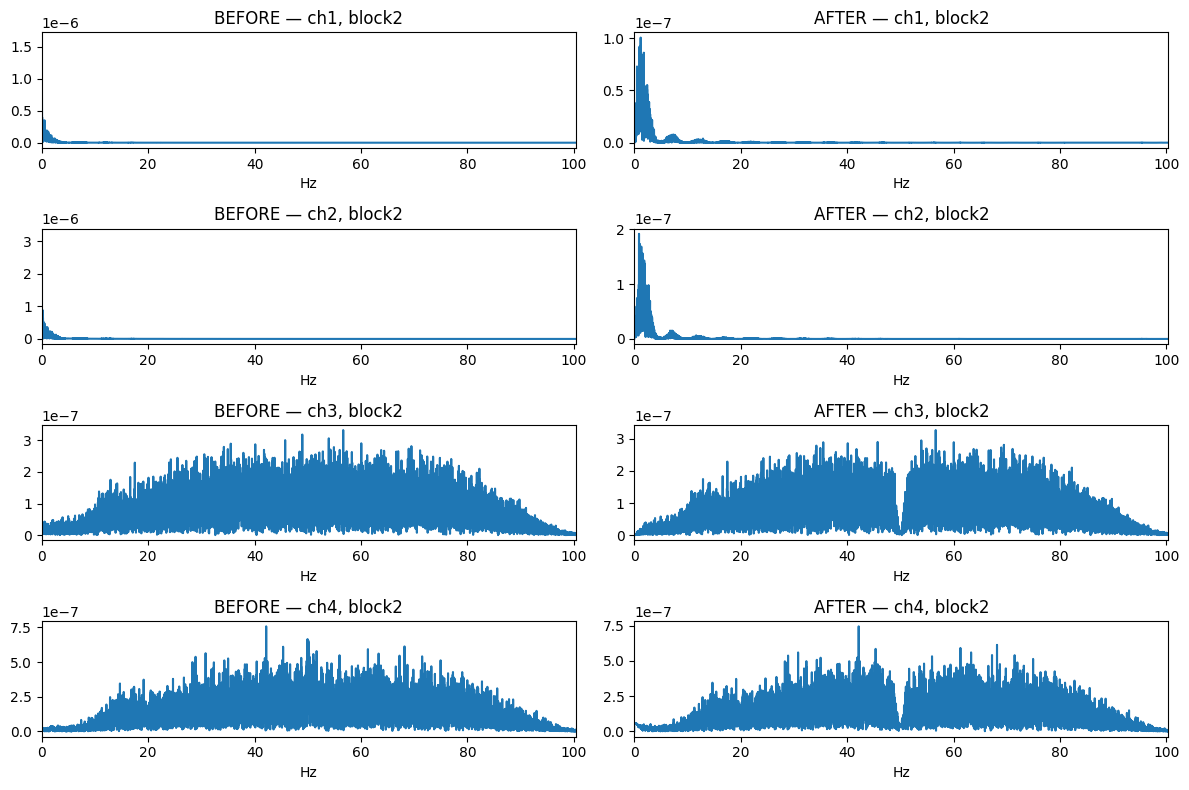

In [21]:
from preprocess import spectrum_fft, highpass_butter, notch_filter
import matplotlib.pyplot as plt

block = 2
fs = Fs_est

plt.figure(figsize=(12,8))

for channel in range(1,5):
    x, locs, labels = get_record_from_cache(cache, channel, block)

    # filtering
    x_hp = highpass_butter(x, fs, fc=1.0, order=1)
    x_f  = notch_filter(x_hp, fs, f0=50.0, q=30.0)

    # spectrum
    f_before, m_before = spectrum_fft(x, fs)
    f_after,  m_after  = spectrum_fft(x_f, fs)

    plt.subplot(4,2,(channel-1)*2+1)
    plt.plot(f_before, m_before)
    plt.title(f"BEFORE — ch{channel}, block{block}")
    plt.xlim(0, fs/2)
    plt.xlabel("Hz")

    plt.subplot(4,2,(channel-1)*2+2)
    plt.plot(f_after, m_after)
    plt.title(f"AFTER — ch{channel}, block{block}")
    plt.xlim(0, fs/2)
    plt.xlabel("Hz")

plt.tight_layout()
plt.show()

In [17]:
from preprocess import preprocess_npz_cache
from pathlib import Path

NPZ_IN = NPZ_PATH  
NPZ_OUT = PROJECT_ROOT / "data" / "processed" / "emg_cache_filtered.npz"

out_path = preprocess_npz_cache(NPZ_IN, NPZ_OUT, fs=Fs_est)
print("Saved filtered cache:", out_path)

Saved filtered cache: c:\Users\Notebook\emg-hand-gesture-classification\data\processed\emg_cache_filtered.npz


----------------------------------

In [32]:
import importlib
import preprocess
importlib.reload(preprocess)

from preprocess import split_blocks_80_20, fit_channel_zscore_params_from_cache, apply_channel_zscore_to_cache
from preprocess import build_window_dataset_from_cache


#### Task 2: Split (80 / 20) + Normalization

In [28]:
from preprocess import split_blocks_80_20, fit_channel_zscore_params_from_cache, apply_channel_zscore_to_cache

all_blocks = list(range(1, 11))
train_blocks, test_blocks = split_blocks_80_20(all_blocks, seed=42)

print("train_blocks:", train_blocks)
print("test_blocks:", test_blocks)

channels = [1, 2, 3, 4]
params = fit_channel_zscore_params_from_cache(cache, train_blocks, channels)
params

train_blocks: [1, 2, 3, 4, 5, 8, 9, 10]
test_blocks: [6, 7]


{1: (2.6719144398382424e-05, 4.3187002123670304e-05),
 2: (2.1840305276012915e-05, 1.0252781744552812e-05),
 3: (-6.724602153809647e-06, 5.0911563268670375e-05),
 4: (-4.7094821448222394e-06, 2.3682048007342098e-05)}

In [29]:
cache_norm = apply_channel_zscore_to_cache(cache, train_blocks + test_blocks, channels, params)

import numpy as np

for ch in channels:
    xs = []
    for b in train_blocks:
        xs.append(cache_norm[f"ch{ch:02d}_b{b:02d}__data"].reshape(-1))
    x_all = np.concatenate(xs)
    print(f"ch{ch}: mean={x_all.mean():.3f}, std={x_all.std():.3f}")

ch1: mean=-0.000, std=1.000
ch2: mean=0.000, std=1.000
ch3: mean=0.000, std=1.000
ch4: mean=0.000, std=1.000


In [30]:
import numpy as np
from pathlib import Path

NPZ_NORM = PROJECT_ROOT / "data" / "processed" / "emg_cache_norm.npz"
NPZ_NORM.parent.mkdir(parents=True, exist_ok=True)

np.savez_compressed(NPZ_NORM, **cache_norm)
print("Saved normalized cache:", NPZ_NORM)

Saved normalized cache: c:\Users\Notebook\emg-hand-gesture-classification\data\processed\emg_cache_norm.npz


--------------------------

#### Task 3

Saving the windows extracted from each channel and inspecting the data structure

In [40]:
from preprocess import build_window_dataset_from_cache
import numpy as np

fs = Fs_est

channels = [1,2,3,4]

Xtr_list = []
Xte_list = []

for ch in channels:
    Xtr, y_train = build_window_dataset_from_cache(cache_norm, train_blocks, channel=ch, fs=fs)
    Xte, y_test  = build_window_dataset_from_cache(cache_norm, test_blocks,  channel=ch, fs=fs)

    Xtr_list.append(Xtr)
    Xte_list.append(Xte)

X_train = np.stack(Xtr_list, axis=1)
X_test  = np.stack(Xte_list, axis=1)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Labels:", len(set(y_train)))

Train: (81816, 4, 40)
Test: (20494, 4, 40)
Labels: 16


In [41]:
import numpy as np
from pathlib import Path

SAVE_PATH = PROJECT_ROOT / "data" / "processed" / "emg_windows_all_channels.npz"
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    SAVE_PATH,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    fs=fs
)

print("Saved full window dataset:")
print(SAVE_PATH)

Saved full window dataset:
c:\Users\Notebook\emg-hand-gesture-classification\data\processed\emg_windows_all_channels.npz


In [42]:
z = np.load(SAVE_PATH, allow_pickle=True)
print("Loaded keys:", z.files)
print("X_train:", z["X_train"].shape, "y_train:", z["y_train"].shape)
print("X_test:", z["X_test"].shape, "y_test:", z["y_test"].shape)
print("fs:", float(z["fs"]))

Loaded keys: ['X_train', 'y_train', 'X_test', 'y_test', 'fs']
X_train: (81816, 4, 40) y_train: (81816,)
X_test: (20494, 4, 40) y_test: (20494,)
fs: 200.8


---------------------------------------

#### Task 4

Creating dataframes for each window's features and saving them

In [43]:
import pandas as pd
from features import extract_features_all

df_train = extract_features_all(X_train, channel_names=["ch1","ch2","ch3","ch4"], include_cor=True)
df_train["label"] = y_train

df_test = extract_features_all(X_test, channel_names=["ch1","ch2","ch3","ch4"], include_cor=True)
df_test["label"] = y_test

df_train.shape, df_test.shape, df_train.head()

((81816, 43),
 (20494, 43),
     MAV_ch1    IAV_ch1   RMS_ch1       VAR_ch1   STD_ch1    WL_ch1  ZC_ch1  \
 0  0.458293  18.331702  0.458293  1.087503e-07  0.000330  0.003523       0   
 1  0.458199  18.327969  0.458200  2.529008e-07  0.000503  0.004179       0   
 2  0.458064  18.322558  0.458065  5.530026e-07  0.000744  0.005054       0   
 3  0.457881  18.315225  0.457882  1.084579e-06  0.001041  0.005835       0   
 4  0.457675  18.307001  0.457677  1.745308e-06  0.001321  0.006250       0   
 
    SSC_ch1  NP_ch1   MAV_ch2  ...  ZC_ch4  SSC_ch4  NP_ch4   Cor_1_2  \
 0       14       7  1.063363  ...      19       24       8 -0.528734   
 1       13       6  1.078664  ...      18       24       8 -0.607681   
 2       12       6  1.094378  ...      18       25       7 -0.662841   
 3       11       5  1.110079  ...      19       24       7 -0.703572   
 4        9       4  1.125522  ...      19       24       8 -0.749762   
 
     Cor_1_3   Cor_1_4   Cor_2_3   Cor_2_4   Cor_3_4  la

In [44]:
from pathlib import Path

OUT_DIR = PROJECT_ROOT / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

train_path = OUT_DIR / "features_train.csv"
test_path  = OUT_DIR / "features_test.csv"

df_train.to_csv(train_path, index=False)
df_test.to_csv(test_path, index=False)

print("Saved training features to:", train_path)
print("Saved test features to:", test_path)

Saved training features to: c:\Users\Notebook\emg-hand-gesture-classification\data\processed\features_train.csv
Saved test features to: c:\Users\Notebook\emg-hand-gesture-classification\data\processed\features_test.csv


In [45]:
import pandas as pd

df_check = pd.read_csv(train_path)
print(df_check.shape)
df_check.head()

(81816, 43)


,MAV_ch1,IAV_ch1,RMS_ch1,VAR_ch1,STD_ch1,WL_ch1,ZC_ch1,SSC_ch1,NP_ch1,MAV_ch2,...,ZC_ch4,SSC_ch4,NP_ch4,Cor_1_2,Cor_1_3,Cor_1_4,Cor_2_3,Cor_2_4,Cor_3_4,label
0,0.458293,18.331702,0.458293,1.087503e-07,0.000330,0.003523,0,14,7,1.063363,...,19,24,8,-0.528734,-0.182649,-0.097516,-0.090726,0.079699,0.281460,Rest
1,0.458199,18.327969,0.458200,2.529008e-07,0.000503,0.004179,0,13,6,1.078664,...,18,24,8,-0.607681,-0.109007,-0.085926,-0.072127,0.138472,0.268969,Rest
2,0.458064,18.322558,0.458065,5.530026e-07,0.000744,0.005054,0,12,6,1.094378,...,18,25,7,-0.662841,0.109692,-0.044415,-0.201420,0.028500,0.340601,Rest
3,0.457881,18.315225,0.457882,1.084579e-06,0.001041,0.005835,0,11,5,1.110079,...,19,24,7,-0.703572,-0.131392,0.049616,-0.084806,-0.089451,0.308534,Rest
4,0.457675,18.307001,0.457677,1.745308e-06,0.001321,0.006250,0,9,4,1.125522,...,19,24,8,-0.749762,0.021483,0.038987,-0.139500,-0.109309,0.336822,Rest
